#### Feature Selection must be used before hyperparameter tuning and model selection

- [1. Feature variance threshold method](#1.-Lowest-Variance-threshold-method)
- [2. K-best features method](#2.-K-best-features-method)
- [3. Recursive Feature Elimination (RFE) method](#3.-Recursive-Feature-Elimination-(RFE)-method)
- [4. Recursive Feature Elimination with Cross-Validation (RFECV) method](#4.-Recursive-Feature-Elimination-with-Cross-Validation-(RFECV)-method)
- [5. Boruta method](#5.-Boruta-method)

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from boruta import BorutaPy
from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, RFECV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Settings

In [2]:
plt.rcParams['figure.figsize'] = (12, 9)

### Load Dataset

In [3]:
wine_data = load_wine()

### Read Data

In [4]:
wine_df = pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)
wine_df['target'] = wine_data.target

In [5]:
wine_df.head(10)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0,0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0,0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0,0
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0,0
9,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0,0


C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


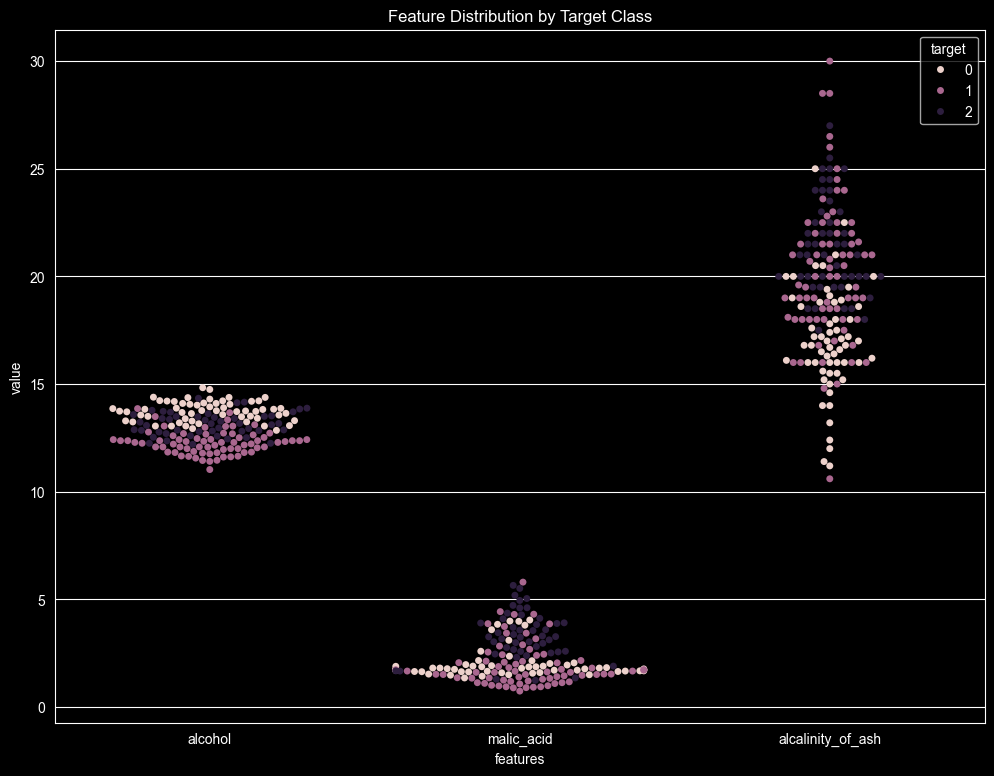

In [6]:
data_to_plot = pd.melt(wine_df[['alcohol', 'malic_acid', 'alcalinity_of_ash', 'target']],
                       id_vars='target',
                       var_name='features',
                       value_name='value')

sns.swarmplot(data=data_to_plot, x='features', y='value', hue='target')
plt.title('Feature Distribution by Target Class')
plt.show()

In [7]:
wine_df['target'].value_counts() # distribution of target classes

target
1    71
0    59
2    48
Name: count, dtype: int64

## Bar Plot Example for Categorical Feature

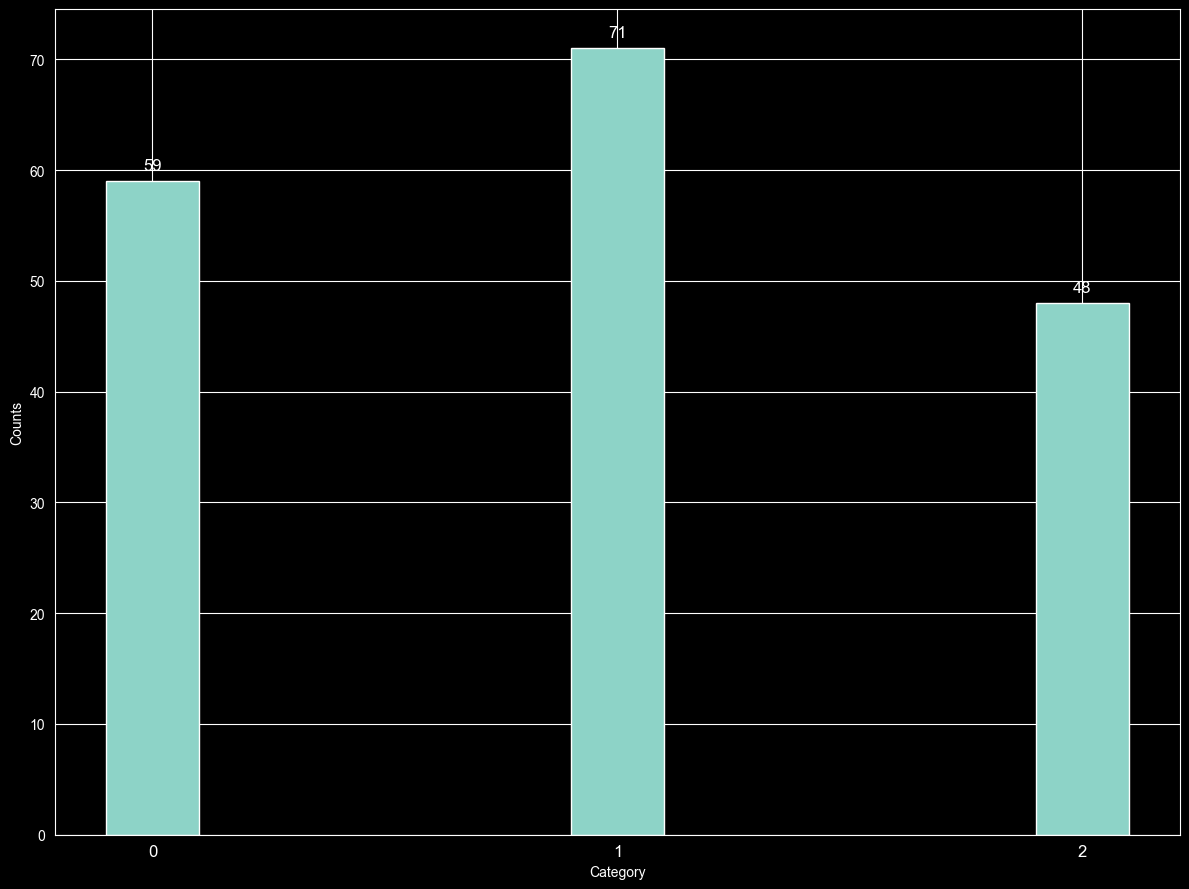

In [8]:
fig, ax = plt.subplots()

x = [0,1,2]
y = [59,71,48]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Category')
ax.set_ylabel('Counts')
ax.set_xticks(x)
ax.set_xticklabels(['0', '1', '2'], fontsize=12)

for index, value in enumerate(y):
    ax.text(x=index, y=value + 1, s=str(value), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## Train/Test Split

In [9]:
X, y = wine_df.drop(columns=['target']), wine_df['target']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=y)

## Baseline model: Gradient Boosting Classifier with all features

In [11]:
gbc_model = GradientBoostingClassifier(random_state=42, n_estimators=5)

gbc_model.fit(X_train, y_train)

y_pred = gbc_model.predict(X_test)

f1_gbc_score = f1_score(y_test, y_pred, average='weighted')

print(f1_gbc_score)

0.9077681577681579


## 1. Lowest Variance threshold method

In [12]:
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=y)

In [13]:
# calculate variance for each feature
X_train_v1.var(axis=0)

alcohol                             0.658341
malic_acid                          1.123507
ash                                 0.072433
alcalinity_of_ash                  11.471279
magnesium                         232.071532
total_phenols                       0.393226
flavanoids                          0.912299
nonflavanoid_phenols                0.013873
proanthocyanins                     0.335108
color_intensity                     5.669722
hue                                 0.052891
od280/od315_of_diluted_wines        0.470021
proline                         94906.710923
dtype: float64

In [14]:
# If feature variance has not the same scale as the target variable, we need to scale it first
scaler = MinMaxScaler()

X_train_v1_scaled = pd.DataFrame(scaler.fit_transform(X_train_v1), columns=X_train_v1.columns)

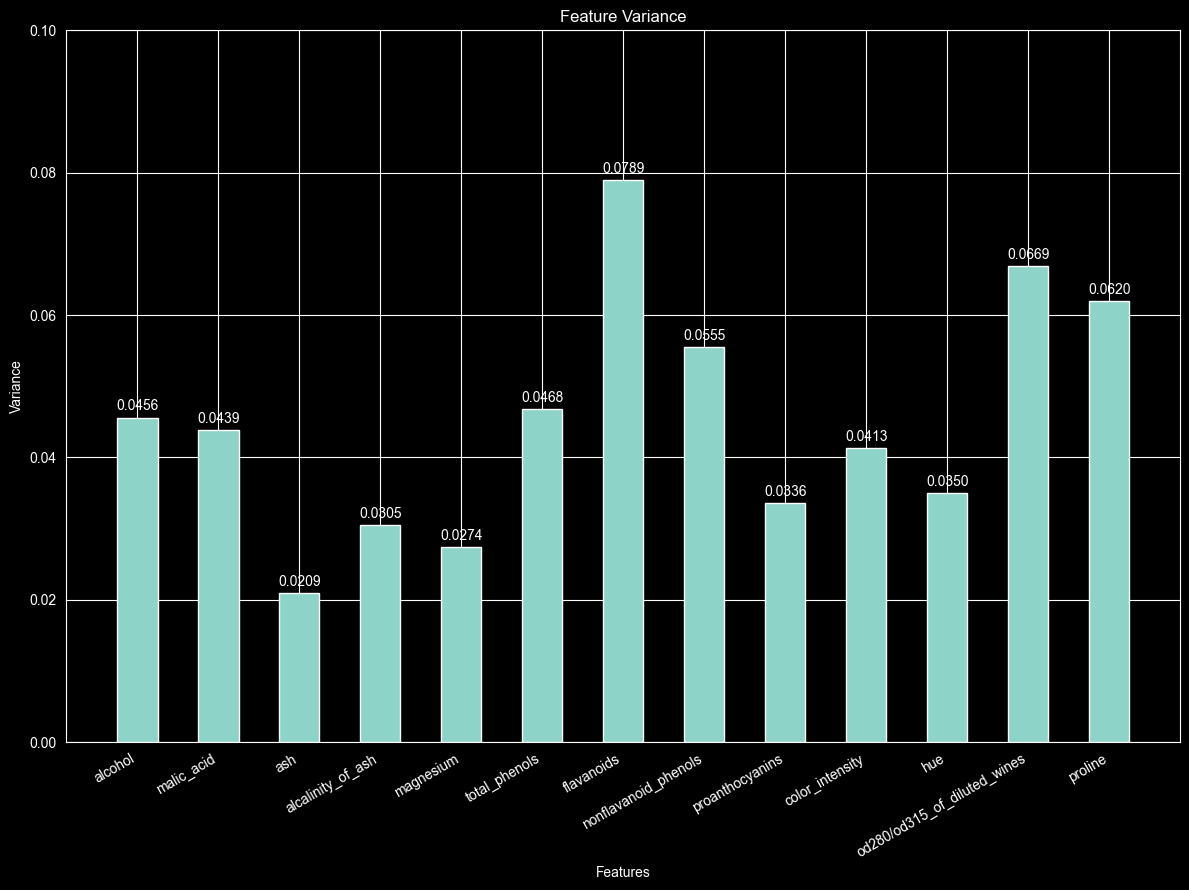

In [15]:
fig, ax = plt.subplots()

x = X.columns
y = X_train_v1_scaled.var(axis=0)

ax.bar(x, y, width=0.5)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    ax.text(x=index, y=value + 0.001, s=f"{value:.4f}", ha='center', fontsize=10)

fig.autofmt_xdate()
plt.title('Feature Variance')
plt.tight_layout()
plt.show()

In [17]:
sel_X_train_v1 = X_train_v1.drop(columns=['magnesium', 'ash'])
sel_X_test_v1 = X_test_v1.drop(columns=['magnesium', 'ash'])

gbc_model_v1 = GradientBoostingClassifier(random_state=42, n_estimators=5)
gbc_model_v1.fit(sel_X_train_v1, y_train_v1)

y_pred_v1 = gbc_model_v1.predict(sel_X_test_v1)

f1_gbc_v1_score = f1_score(y_test_v1, y_pred_v1, average='weighted')

print(f"F1 Score with Variance Threshold: {f1_gbc_v1_score:.4f}")

F1 Score with Variance Threshold: 0.9632


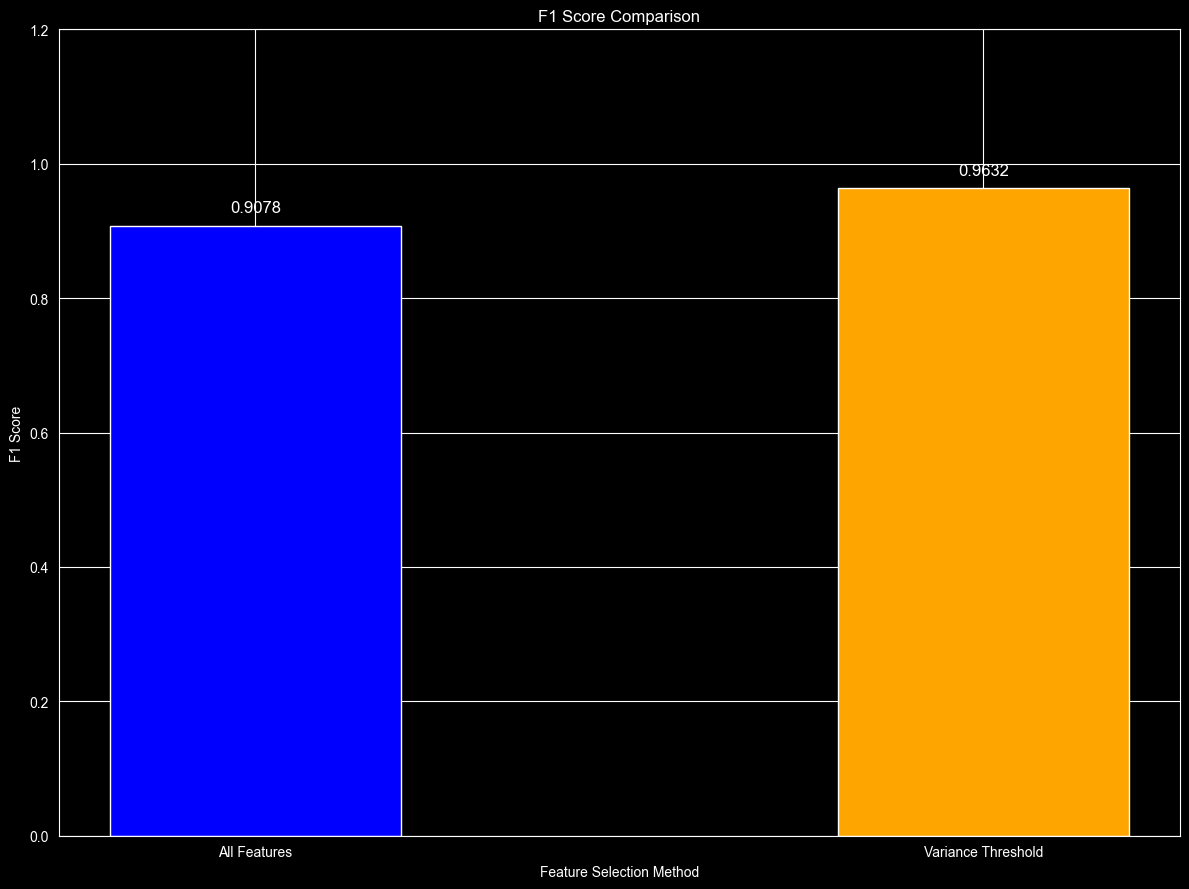

In [18]:
fig, ax = plt.subplots()

x= ['All Features', 'Variance Threshold']
y = [f1_gbc_score, f1_gbc_v1_score]

ax.bar(x, y, width=0.4, color=['blue', 'orange'])
ax.set_ylabel('F1 Score')
ax.set_xlabel('Feature Selection Method')
ax.set_ylim(0, 1.2)

for index, value in enumerate(y):
    ax.text(x=index, y=value + 0.02, s=f"{value:.4f}", ha='center', fontsize=12)

plt.title('F1 Score Comparison')
plt.tight_layout()
plt.show()

## 2. K-best features method
- use a measure of importance to select the top K features

Select metrics criteria for K-best features method

| Target/Features | Categorical                            | Numerical                                                        |
|-----------------|----------------------------------------|------------------------------------------------------------------|
| Categorical     | Chi2 <br/> Mutual Info                 | t-test<br/> Mutual Info                                          |
| Numerical       | ANOVA, <br/> t-test, <br/> Mutual Info | Pearson Correlation <br/> Spearman`s rank corr <br/> Mutual Info |

In [22]:
X, y = wine_df.drop(columns=['target']), wine_df['target']

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=y)

In [23]:
f1_score_list = []

for k in range(1, X_train_v2.shape[1]+1):

    selector = SelectKBest(score_func=mutual_info_classif, k=k) # our case is classification with numerical features

    X_train_v2_selected = selector.fit_transform(X_train_v2, y_train_v2)
    X_test_v2_selected = selector.transform(X_test_v2)

    gbc_model_v2 = GradientBoostingClassifier(random_state=42, n_estimators=5)
    gbc_model_v2.fit(X_train_v2_selected, y_train_v2)

    y_pred_v2 = gbc_model_v2.predict(X_test_v2_selected)

    f1_gbc_v2_score = f1_score(y_test_v2, y_pred_v2, average='weighted')

    f1_score_list.append(f1_gbc_v2_score)

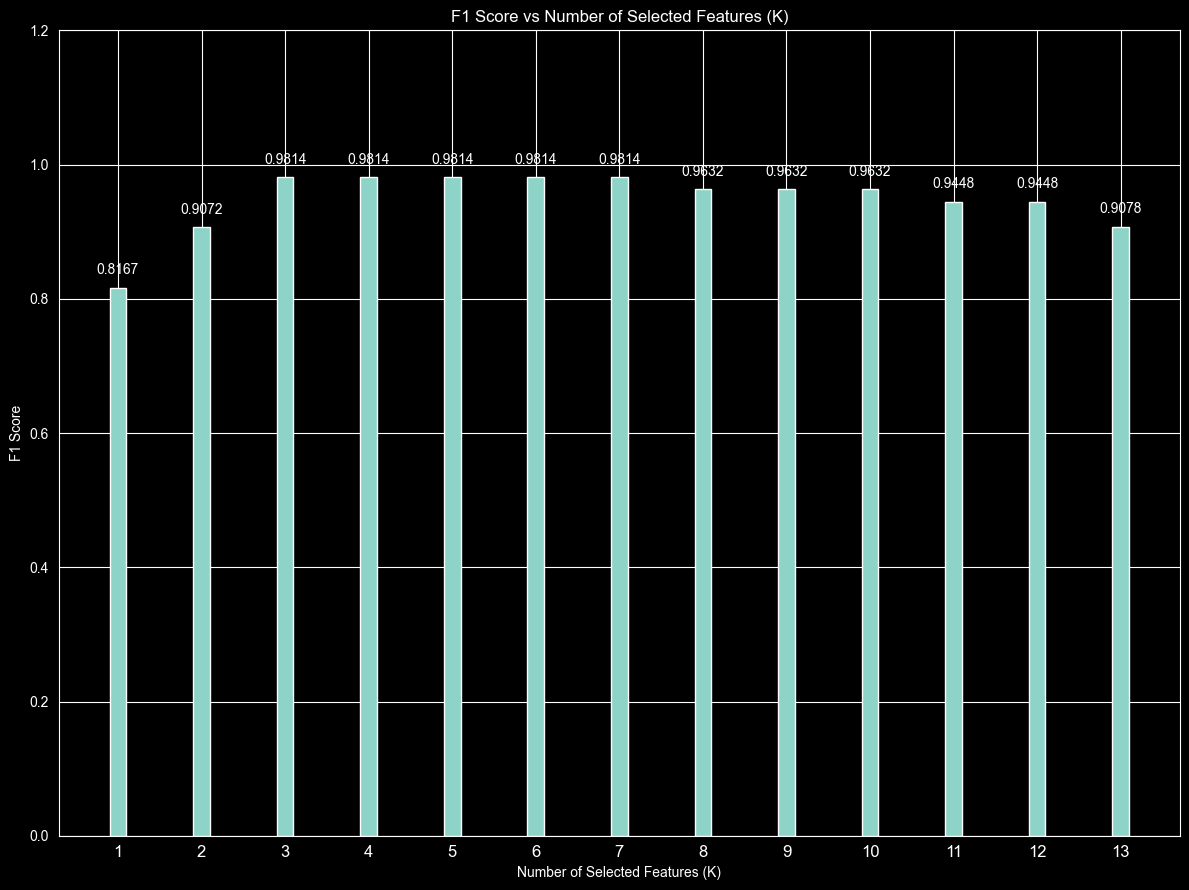

In [24]:
fig, ax = plt.subplots()
x = list(range(1, X_train_v2.shape[1]+1))
y = f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of Selected Features (K)')
ax.set_ylabel('F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(x, fontsize=12)
ax.set_ylim(0, 1.2)

for index, value in enumerate(y):
    ax.text(x=index + 1, y=value + 0.02, s=f"{value:.4f}", ha='center', fontsize=10)

plt.title('F1 Score vs Number of Selected Features (K)')
plt.tight_layout()
plt.show()

In [25]:
# at leash 3 features are needed to reach the baseline score
selector = SelectKBest(score_func=mutual_info_classif, k=3)

X_train_v2_selected = selector.fit_transform(X_train_v2, y_train_v2)
selected_feature_mask = selector.get_support()
selected_features = X_train_v2.columns[selected_feature_mask]
print('Most Important Features (K=3):')
print("Selected Features:", selected_features.tolist())

Most Important Features (K=3):
Selected Features: ['flavanoids', 'color_intensity', 'proline']


## 3. Recursive Feature Elimination (RFE) method
- use an external model to assign weights to features and eliminate the least important ones recursively

In [26]:
X, y = wine_df.drop(columns=['target']), wine_df['target']

X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=y)

In [27]:
rfe_f1_score_list = []

for k in range(1, X_train_v3.shape[1]+1):

    rfe = RFE(estimator=GradientBoostingClassifier(random_state=42,
                                                   n_estimators=5),
              n_features_to_select=k, # number of features to select
              step=1,
              verbose=0) # for large datasets, use step>1 to speed up the process

    X_train_v3_selected = rfe.fit_transform(X_train_v3, y_train_v3)
    X_test_v3_selected = rfe.transform(X_test_v3)

    gbc_model_v3 = GradientBoostingClassifier(random_state=42, n_estimators=5)
    gbc_model_v3.fit(X_train_v3_selected, y_train_v3)

    y_pred_v3 = gbc_model_v3.predict(X_test_v3_selected)

    f1_gbc_v3_score = f1_score(y_test_v3, y_pred_v3, average='weighted')

    rfe_f1_score_list.append(f1_gbc_v3_score)

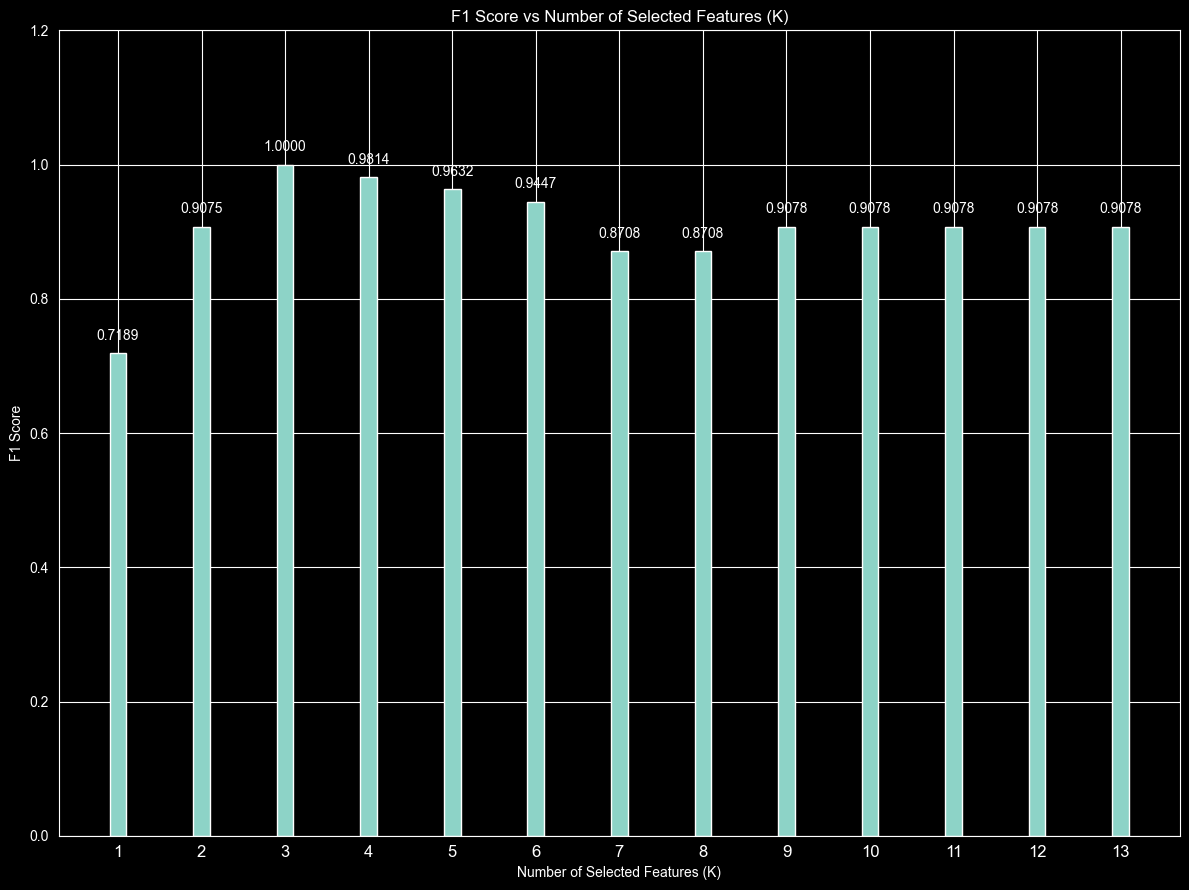

In [28]:
fig, ax = plt.subplots()
x = list(range(1, X_train_v3.shape[1]+1))
y = rfe_f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of Selected Features (K)')
ax.set_ylabel('F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(x, fontsize=12)
ax.set_ylim(0, 1.2)

for index, value in enumerate(y):
    ax.text(x=index + 1, y=value + 0.02, s=f"{value:.4f}", ha='center', fontsize=10)

plt.title('F1 Score vs Number of Selected Features (K)')
plt.tight_layout()
plt.show()

In [29]:
# at leash 3 features are needed to reach the baseline score
rfe = RFE(estimator=GradientBoostingClassifier(random_state=42,
                                               n_estimators=5),
          n_features_to_select=3, # number of features to select
          step=1,
          verbose=0) # for large datasets, use step>1 to speed up the process

X_train_v3_selected = rfe.fit_transform(X_train_v3, y_train_v3)
selected_feature_mask = rfe.get_support()
selected_features = X_train_v3.columns[selected_feature_mask]
print('Most Important Features (K=3):')
print("Selected Features:", selected_features.tolist())

Most Important Features (K=3):
Selected Features: ['color_intensity', 'od280/od315_of_diluted_wines', 'proline']


## 4. Recursive Feature Elimination with Cross-Validation (RFECV) method
- use an external model to assign weights to features and eliminate the least important ones recursively with cross-validation to find the optimal number of features

In [31]:
X, y = wine_df.drop(columns=['target']), wine_df['target']

X_train_v4, X_test_v4, y_train_v4, y_test_v4 = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=y)

In [32]:
rfecv_f1_score_list = []

for k in range(1, X_train_v4.shape[1]+1):

    rfecv = RFECV(estimator=GradientBoostingClassifier(random_state=42,
                                                       n_estimators=5),
                  min_features_to_select=k, # minimum number of features to select
                  step=1,
                  cv=5, # number of folds in cross-validation
                  scoring='accuracy',
                  verbose=0) # for large datasets, use step>1 to speed up the process

    X_train_v4_selected = rfecv.fit_transform(X_train_v4, y_train_v4)
    X_test_v4_selected = rfecv.transform(X_test_v4)

    gbc_model_v4 = GradientBoostingClassifier(random_state=42, n_estimators=5)
    gbc_model_v4.fit(X_train_v4_selected, y_train_v4)

    y_pred_v4 = gbc_model_v4.predict(X_test_v4_selected)

    f1_gbc_v4_score = f1_score(y_test_v4, y_pred_v4, average='weighted')

    rfecv_f1_score_list.append(f1_gbc_v4_score)

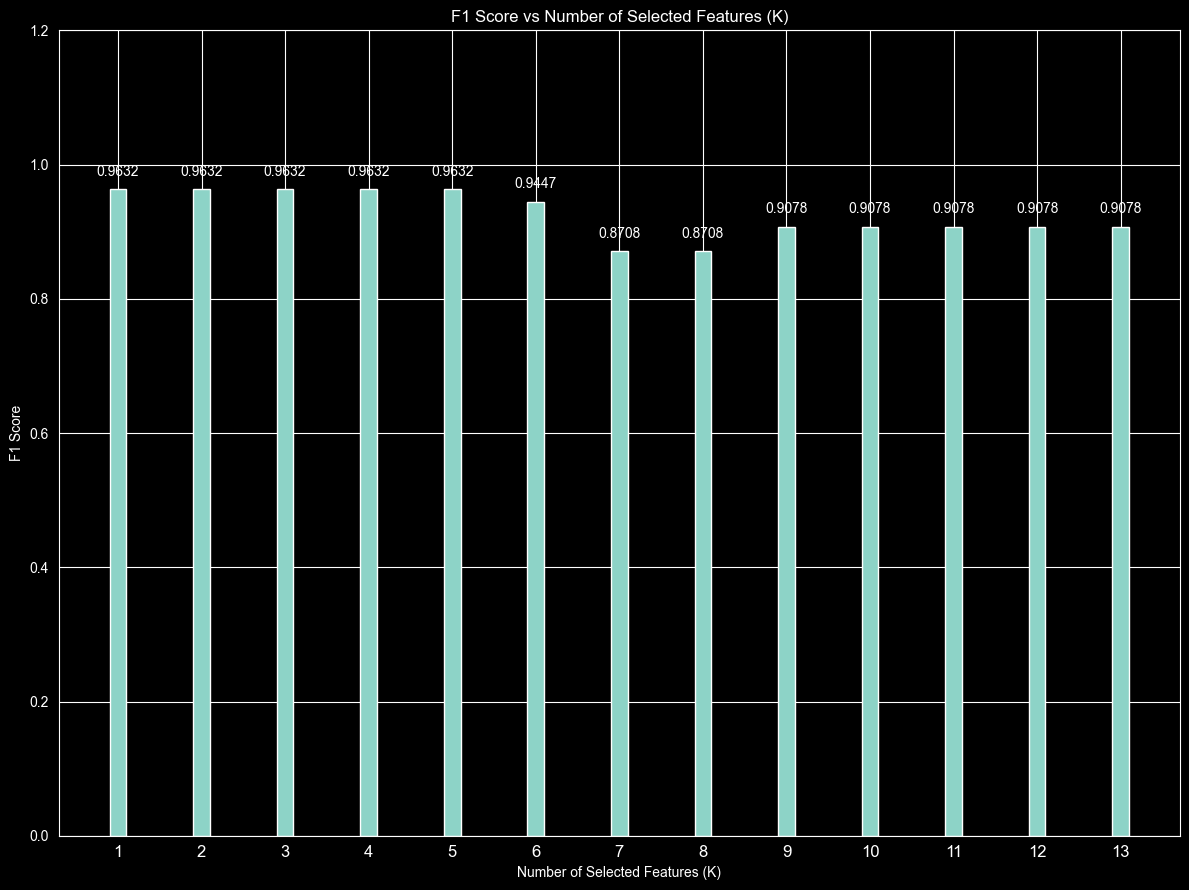

In [33]:
# plot the RFECV results
fig, ax = plt.subplots()
x = list(range(1, X_train_v4.shape[1]+1))
y = rfecv_f1_score_list
ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of Selected Features (K)')
ax.set_ylabel('F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(x, fontsize=12)
ax.set_ylim(0, 1.2)

for index, value in enumerate(y):
    ax.text(x=index + 1, y=value + 0.02, s=f"{value:.4f}", ha='center', fontsize=10)

plt.title('F1 Score vs Number of Selected Features (K)')
plt.tight_layout()
plt.show()

In [34]:
# at leash 3 features are needed to reach the baseline score
rfecv = RFECV(estimator=GradientBoostingClassifier(random_state=42,
                                                   n_estimators=5),
              min_features_to_select=3, # minimum number of features to select
              step=1,
              cv=5, # number of folds in cross-validation
              scoring='accuracy',
              verbose=0) # for large datasets, use step>1 to speed up the process

X_train_v4_selected = rfecv.fit_transform(X_train_v4, y_train_v4)
selected_feature_mask = rfecv.get_support()
selected_features = X_train_v4.columns[selected_feature_mask]

print('Most Important Features (K=3):')
print("Selected Features:", selected_features.tolist())

Most Important Features (K=3):
Selected Features: ['malic_acid', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']


## 5. Boruta method
- use a tree-based model to assign importance to features and select the most important ones by comparing them to their shadow features

In [36]:
X, y = wine_df.drop(columns=['target']), wine_df['target']

X_train_v5, X_test_v5, y_train_v5, y_test_v5 = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=y)

In [37]:
gbc = GradientBoostingClassifier(random_state=42, n_estimators=5)
boruta_selector = BorutaPy(estimator=gbc,
                             random_state=42)

boruta_selector.fit(X_train_v5.values, y_train_v5.values) # quite a slow process 3m 46s

sel_X_train_v5 = boruta_selector.transform(X_train_v5.values)
sel_X_test_v5 = boruta_selector.transform(X_test_v5.values)

gbc.fit(sel_X_train_v5, y_train_v5)

y_pred_v5 = gbc.predict(sel_X_test_v5)
f1_gbc_v5_score = f1_score(y_test_v5, y_pred_v5, average='weighted')

print(f"F1 Score with Boruta: {f1_gbc_v5_score:.4f}")

F1 Score with Boruta: 1.0000


In [38]:
selected_features = X_train_v5.columns[boruta_selector.support_].to_list()
print('Most Important Features (Boruta):')
print("Selected Features:", selected_features)

Most Important Features (Boruta):
Selected Features: ['malic_acid', 'ash', 'flavanoids', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


## Compare all feature selection methods using bar plot

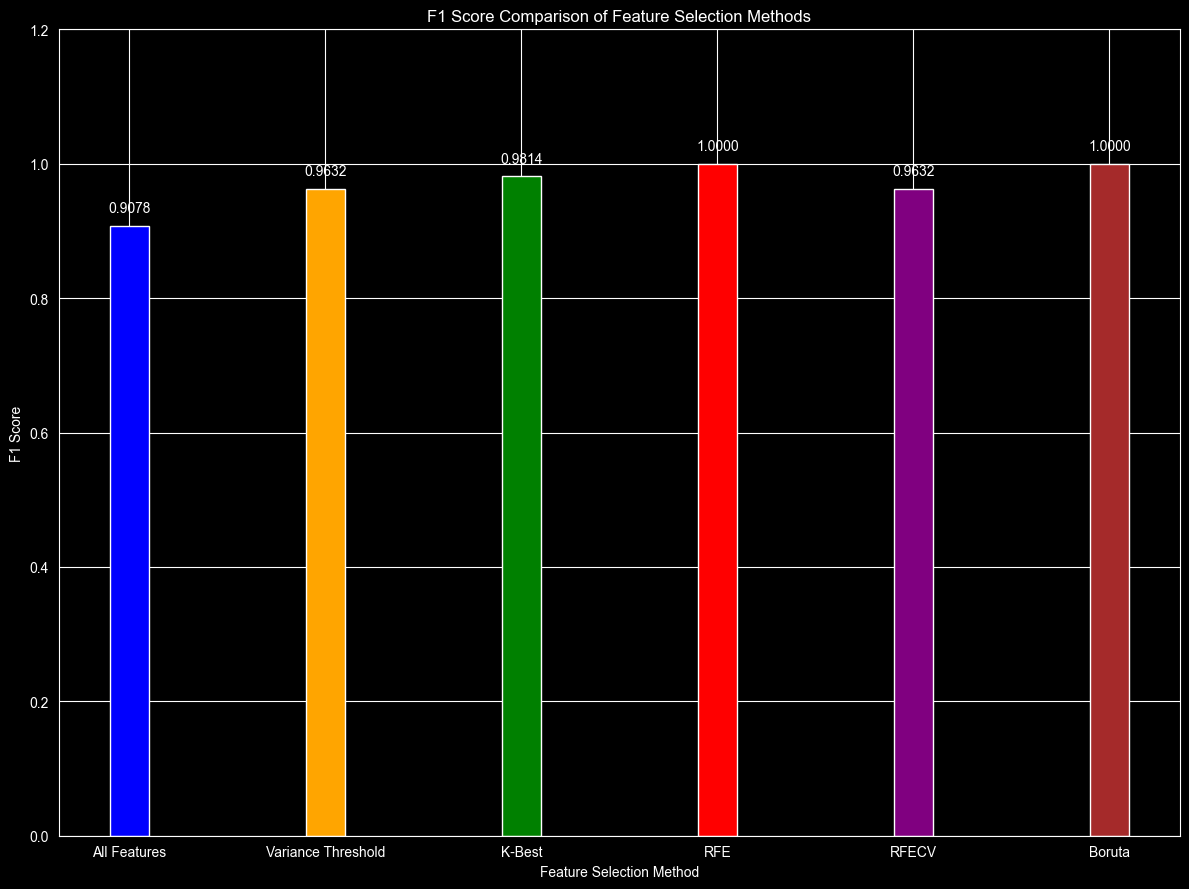

In [39]:
fig, ax = plt.subplots()

x = ['All Features', 'Variance Threshold', 'K-Best', 'RFE', 'RFECV', 'Boruta']
y = [f1_gbc_score, f1_gbc_v1_score, max(f1_score_list), max(rfe_f1_score_list), max(rfecv_f1_score_list), f1_gbc_v5_score]

ax.bar(x, y, width=0.2, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
ax.set_ylabel('F1 Score')
ax.set_xlabel('Feature Selection Method')
ax.set_ylim(0, 1.2)

for index, value in enumerate(y):
    ax.text(x=index, y=value + 0.02, s=f"{value:.4f}", ha='center', fontsize=10)

plt.title('F1 Score Comparison of Feature Selection Methods')
plt.tight_layout()
plt.show()